In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [2]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [3]:
dataset = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [4]:
dataset.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [5]:
for i in dataset.columns:
    print(i,":",dataset[i].nunique())

Sentence # : 47959
Word : 35177
POS : 42
Tag : 17


In [6]:
for i in dataset.columns:
    print(i,":",len(dataset[i].values))

Sentence # : 1048575
Word : 1048575
POS : 1048575
Tag : 1048575


In [7]:
dataset.isnull().sum()

Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64

In [8]:
dataset["Sentence #"].unique()

array(['Sentence: 1', nan, 'Sentence: 2', ..., 'Sentence: 47957',
       'Sentence: 47958', 'Sentence: 47959'], dtype=object)

We see in column "Sentence #" sentence 1 is followed by NaN, so we need to fill the same we whatever the value is in top

In [9]:
dataset = dataset.fillna(method="ffill")

C:\Users\satheeskumar\AppData\Local\Temp\ipykernel_25156\2456240455.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset = dataset.fillna(method="ffill")


In [10]:
dataset.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [40]:
dataset.tail()

,Sentence #,Word,POS,Tag
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [57]:
dataset[dataset["Tag"] == 'I-eve']

,Sentence #,Word,POS,Tag
4854,Sentence: 219,Summer,NNP,I-eve
4855,Sentence: 219,Olympics,NNPS,I-eve
5036,Sentence: 227,Olympic,JJ,I-eve
5171,Sentence: 234,Medusa,NNP,I-eve
5764,Sentence: 262,War,NNP,I-eve
...,...,...,...,...
1027169,Sentence: 46973,Day,NNP,I-eve
1027180,Sentence: 46974,War,NNP,I-eve
1027181,Sentence: 46974,I,NNP,I-eve
1041941,Sentence: 47651,War,NNP,I-eve


In [11]:
dataset.shape

(1048575, 4)

In [12]:
tags = list(set(dataset["Tag"].values))
print("Tags:", tags)

Tags: ['B-nat', 'I-art', 'B-per', 'B-geo', 'B-eve', 'I-nat', 'O', 'B-org', 'I-geo', 'B-art', 'B-gpe', 'I-org', 'I-per', 'I-gpe', 'B-tim', 'I-tim', 'I-eve']


In [13]:
#let's check the frequency of each tag
dataset['Tag'].value_counts()

Tag
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64

In [14]:
words = list(set(dataset["Word"].values))
n_words = len(words)
print("no of unique words in the dataset: ",n_words)

no of unique words in the dataset:  35177


In [15]:
tags = list(set(dataset["Tag"].values))
print("Tags: ", tags)

Tags:  ['B-nat', 'I-art', 'B-per', 'B-geo', 'B-eve', 'I-nat', 'O', 'B-org', 'I-geo', 'B-art', 'B-gpe', 'I-org', 'I-per', 'I-gpe', 'B-tim', 'I-tim', 'I-eve']


In [16]:
n_tags = len(dataset.groupby("Tag"))
print("Number of labels: ",n_tags)

Number of labels:  17


In [17]:
class SentenceGetter(object):
    def __init__(self, dataset):
        self.sentence_n = 1
        self.data = dataset
        self.empty = False
        agg_funct = lambda s: [(w,p,t) for w,p,t in zip(s["Word"].values.tolist(),
                                    s["POS"].values.tolist(),
                                    s["Tag"].values.tolist())
                                   ]

        self.grouped = self.data.groupby("Sentence #").apply(agg_funct)
        self.sentence = [s for s in self.grouped]

    def getnext(self):
        try:
            s = self.grouped["Sentence: {}".format(self.sentence_n)]
            self.sentence_n += 1
            return s
        except:
            None
        
getter = SentenceGetter(dataset)
sent = getter.getnext()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


C:\Users\satheeskumar\AppData\Local\Temp\ipykernel_25156\364474339.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence #").apply(agg_funct)


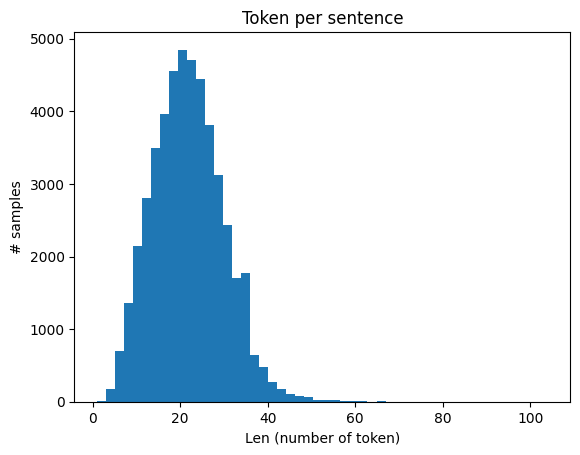

In [18]:
# Get all the sentences
sentences = getter.sentence
# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [19]:
import sklearn

# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}
print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))


The word Obama is identified by the index: 23248
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 4


In [20]:
from keras.preprocessing.sequence import pad_sequences

X = [[word2idx[w[0]] for w in s] for s in sentences]

X = pad_sequences(maxlen = MAX_LEN, sequences = X, padding= "post", value = word2idx["PAD"])

Y = [[tag2idx[w[2]] for w in s] for s in sentences]

Y = pad_sequences(maxlen = MAX_LEN, sequences = Y, padding = "post", value = tag2idx["PAD"])


from keras.utils import to_categorical

Y = [to_categorical(i , num_classes=n_tags+1) for i in Y]

from sklearn.model_selection import train_test_split
x_tr,x_te,y_tr,y_te = train_test_split(X,Y,test_size = 0.1)

x_tr, x_temp, y_tr, y_temp = train_test_split(X, Y, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)


x_tr.shape,x_te.shape,np.array(y_tr).shape,np.array(y_te).shape 

((43163, 75), (4796, 75), (43163, 75, 18), (4796, 75, 18))

In [21]:

print('Raw Sample:\n ', ' '.join([w[0] for w in sentences[0]]))
print('\n ' )
print('Raw Label:\n ', ' '.join([w[2] for w in sentences[0]]))
print('\n ' )
print('After processing, sample:\n', X[0])
print('\n ' )
print('After processing, labels:\n', Y[0])

Raw Sample:
  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .

 
Raw Label:
  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O

 
After processing, sample:
 [ 4840 31934  5805 25576 23311  1527 17655 27118 33438 28708 15404 31913
   401 17722 15958 28708 33797 31934  8333 14376  4999 14651  4356 27671
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]

 
After processing, labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [22]:
y_tr = np.array(y_tr)
y_te = np.array(y_te)

In [23]:
#!pip install tensorflow_addons

In [24]:
from keras.models import Model
from tensorflow.keras.layers import Input 
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike

#lstm
from keras.layers import LSTM, Embedding,Dense, TimeDistributed, Dropout, Bidirectional

#CRF
from tensorflow_addons.layers import CRF

#SIGMOID
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW

def build_model(max_len = 75, input_dim = 35180, embedding_dim = 200):
    input = Input(shape=(max_len,))

    embeddings = Embedding(input_dim = input_dim,
                           output_dim = embedding_dim,
                           input_length=max_len,
                           mask_zero=True,
                          )(input)

    output_sequences = Bidirectional(LSTM(units=50, return_sequences = True))(embeddings)

    output_sequences = Bidirectional(LSTM(units=50, return_sequences = True))(output_sequences)

    dense_out= TimeDistributed(Dense(25, activation = "relu"))(output_sequences)

    crf = CRF(18, name="crf")
    predicted_sequences, potentials, sequence_length,crf_kernel = crf(dense_out)

    model = Model(input,potentials)
    model.compile(
        optimizer = AdamW(weight_decay=0.001),
        loss = SigmoidFocalCrossEntropy())

    return model
model = build_model()

#checkpoints
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='best_model_weights.h5',
                                                   monitor = "val_loss",
                                                   save_weights_only=True,
                                                   save_best_only= True,
                                                   verbose =1)

es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", verbose = 1, patience =10)

callbacks = [save_model,es]
model.summary()

C:\Users\satheeskumar\apps\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75)]              0         
                                                                 
 embedding (Embedding)       (None, 75, 200)           7036000   
                                                                 
 bidirectional (Bidirection  (None, 75, 100)           100400    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 75, 100)           60400     
 onal)                                                           
                                                                 
 time_distributed (TimeDist  (None, 75, 25)            2525      
 ributed)                                                        
                                                             

In [25]:
import tensorflow as tf
import tensorflow_addons as tfa

print(tf.__version__)       # Should be 2.13.0
print(tfa.__version__)      # Should be 0.22.0


2.13.0
0.22.0


In [28]:
history = model.fit(x_tr, y_tr, validation_data = (x_te, y_te), shuffle = True)

1349/1349 [==============================] - 306s 227ms/step - loss: 0.0150 - val_loss: 0.0147


In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_ner_manual(sentence, word2idx, idx2tag, model, max_len=75):
    # Step 1: Tokenize the sentence (just word split)
    tokens = sentence.split()

    # Step 2: Convert to word IDs
    input_ids = [word2idx.get(w, word2idx.get('O', 1)) for w in tokens]  # use 'O' or unknown token index

    # Step 3: Pad the sequence
    input_ids_padded = pad_sequences([input_ids], maxlen=max_len, padding='post')

    # Step 4: Predict
    pred = model.predict(input_ids_padded)
    pred_indices = np.argmax(pred, axis=-1)[0]

    # Step 5: Convert prediction indices back to tags
    predicted_tags = [idx2tag[idx] for idx in pred_indices[:len(tokens)]]

    # Step 6: Display
    return list(zip(tokens, predicted_tags))


In [62]:
sentence = "The International Atomic Energy Agency IAEA promotes the secure, and peaceful use of nuclear energy around the world. is a part of the United Nations UN system"

result = predict_ner_manual(sentence, word2idx, idx2tag, model, max_len=75)

for word, tag in result:
    print(f"{word} --> {tag}")



1/1 [==============================] - 0s 52ms/step
The --> O
International --> B-org
Atomic --> I-org
Energy --> I-org
Agency --> I-org
IAEA --> I-org
promotes --> O
the --> O
secure, --> O
and --> O
peaceful --> O
use --> O
of --> O
nuclear --> O
energy --> O
around --> O
the --> O
world. --> O
is --> O
a --> O
part --> O
of --> O
the --> O
United --> B-geo
Nations --> I-org
UN --> I-org
system --> O
